In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# UNCOMMENT LINES BELOW FOR WINDOWS USE ONLY
import sys
from PIL import Image
sys.modules['Image'] = Image 
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
DATADIR = "dataset/train/"
CATEGORIES = ["lajthiza", "spring", "tepelena"]

# Defining the size of the images expected by MobileNetV2
IMG_SIZE = 224

# Loading images directly from the dataset folder and preprocess them
def load_images():
    X = []
    y = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
         # Iterate through each image file in the category directory
        for img in os.listdir(path):
            if img.endswith(".jpg"):  # Ensure only .jpg files are processed
                try:
                    img_path = os.path.join(path, img)
                      # Load and preprocess the image using Keras preprocessing functions
                    image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                    image = img_to_array(image)
                    image = preprocess_input(image)
                    X.append(image)
                    y.append(class_num)
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
    return np.array(X), np.array(y)

# Loading the images and labels
X, y = load_images()

# Verifying the shape of the loaded data
print(f"Loaded images shape: {X.shape}")
print(f"Loaded labels shape: {y.shape}")


Loaded images shape: (969, 224, 224, 3)
Loaded labels shape: (969,)


In [3]:
# Determine the number of classes in the labels

num_classes = len(np.unique(y))  # Automatically determine number of classes
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

# Spliting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation sets to verify correctness
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (775, 224, 224, 3)
y_train shape: (775, 3)
X_val shape: (194, 224, 224, 3)
y_val shape: (194, 3)


In [4]:
# Load MobileNetV2 pretrained on ImageNet without the top classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

# Construct the final classification layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compiling the model for training
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [5]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

# Evaluating the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6470 - loss: 0.7380 - val_accuracy: 1.0000 - val_loss: 0.0302
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9897 - loss: 0.0570 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9902 - loss: 0.0250 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9976 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9990 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9976 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 9.0232e-04
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 1.0000 - val_l

In [6]:
model.save('water_bottle_classifier_mobilenetv2_pretrained.h5')

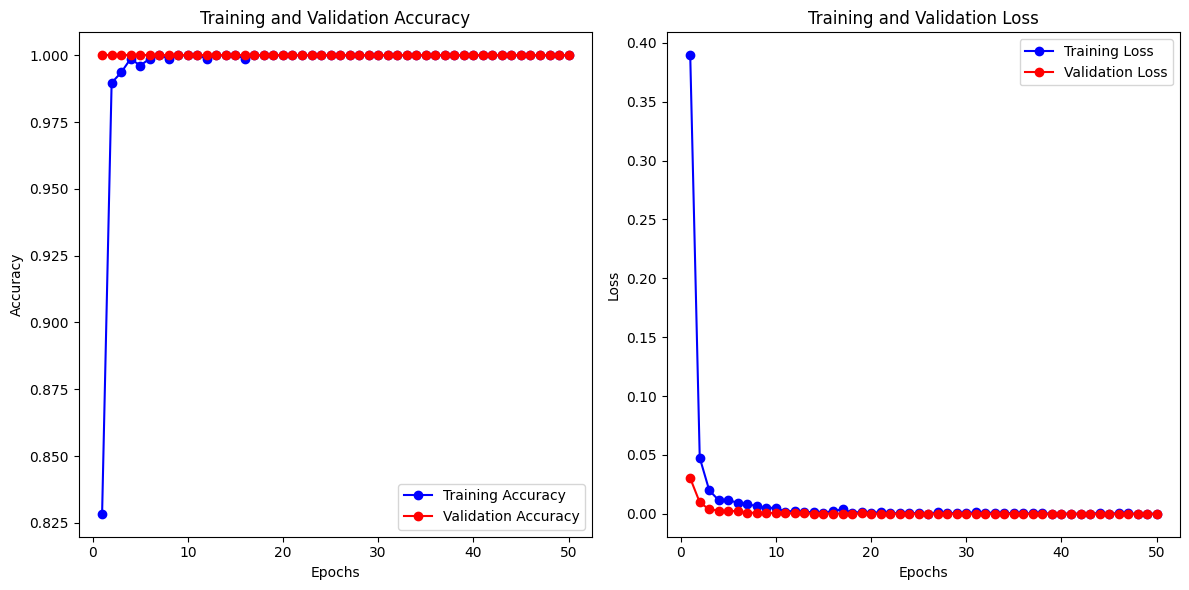

In [7]:
epochs = range(1, 51)

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()